# 计算机视觉

## 一、图片增广

## 二、图片微调

## 三、目标检测和边界框

对于实际情况中，一个图片通常包括多个我们感兴趣的目标，我们不仅想知道它们的类别，还想知道他们在图片中的具体位置。这个问题在计算机视觉中，也被成为<font color="red">目标检测（object detection）</font>或<font color="red">目标识别（object recognition）</font>。

目标检测在多个领域中被广泛使用。 例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍物的位置来规划行进线路。 机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

下面首先介绍目标的位置：

In [143]:
import torch
from d2l import torch as d2l

下面加载一张包括猫和狗的图片`cat_dog.jpg`，图中包括猫和狗两个检测目标

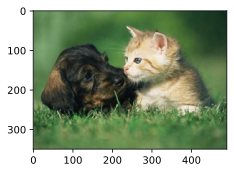

In [144]:
d2l.set_figsize()
img = d2l.plt.imread('./assets/cat_dog.jpg')
d2l.plt.imshow(img)

在目标检测中，我们通常使用**边界框**（bounding box）来描述对象的空间位置。边界框是矩形的，由矩形左上角以及右下角的$x$和$y$坐标决定。另一种常用的边界框表示方法是边界框中心的$(x,y)$轴坐标以及框的宽度和高度。



In [145]:
#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [146]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [20.0, 80.0, 225.0, 265.0], [230.0, 42.0, 425.0, 263.0]

boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [147]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

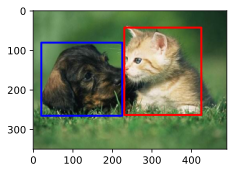

In [148]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 四、锚框

目标检测算法通常通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更准确地预测目标的**真实边界框（ground-truth bounding box）**。不同的模型使用的区域采样方法可能不同，本文使用其中其中一种方法：以每个像素为中心，生成多个缩放比和宽高比（aspect ratio）不同的边界框。这种边界框被称为**锚框（anchor box）**。

首先修改输出精度，以获得更加简洁的输出：

In [149]:
# 精简输出精度
torch.set_printoptions(2)

### 4.1 生成多个锚框

假设输入图片的高度为$h$，宽度为$w$。以图像的每个像素为中心生成不同形状的锚框：*缩放比*为$s \in (0,1]$，*宽高比*为$r>0$。那么锚框的宽度和高度分别为$ws\sqrt{r}$和$hs\sqrt{r}$。请注意，当中心位置给定时，已知宽和高的锚框是确定的。

要生成多个不同形状的锚框，我们需要设置许多缩放比（scale）取值$s_1,...,s_n$和许多宽高比（aspect ratio）取值$r_1,...,r_m$。但是，当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有$whnm$个锚框，使得计算复杂性很高。在实际应用中我们只考虑包含$s_1$或$r_1$的组合：

$$(s_1,r_1),(s_2,r_2),...,(s_1,r_m),(s_2,r_1)(s_3,r_1),...,(s_n,r_1).$$

因此，以同一个像素为中心的锚框的数量是$n+m-1$。对于整个输入图像，共生成$wh(n+m-1)$个锚框。

> 上面的生成锚框的方法可以通过`multibox_prior`函数实现：指定输入图像、尺寸列表和宽高比列表，然后`multibox_prior`函数将放回所有的锚框。

In [150]:
def multibox_prior(data, sizes, ratios):

    """函数功能：生成以每个像素为中心具有不同形状的锚框

    Args:
        data (_type_): 输入的图片
        sizes (list): 缩放比
        ratios (list): 宽高比
    """

    # 获取图片的高度和宽度
    in_height, in_width = data.shape[-2:]
    # 获取图片数据的处理设备、缩放比数量、宽高比数量
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 每个像素的锚框数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    # 将缩放比sizes和宽高比rci shuatios转变为张量
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素中心，需要设置偏移量。因为一个像素的高和宽均为1，选择偏移的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height   # 在y轴上缩放步长
    steps_w = 1.0 / in_width    # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # 生成锚框中心点网格
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    # 将生成的锚框中心点网格拉伸为向量
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，然后用于创建锚框的四角坐标(xmin, xmax, ymin, ymax)
    w = torch.cat(
        (
            size_tensor * torch.sqrt(ratio_tensor[0]),
            sizes[0] * torch.sqrt(ratio_tensor[1:])
        )
    ) * in_height / in_width

    h = torch.cat(
        (
            size_tensor / torch.sqrt(ratio_tensor[0]),
            sizes[0] / torch.sqrt(ratio_tensor[1:])
        )
    )
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)
    ).T.repeat(in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，所以生成含有所有锚框中心的网格，重复了“boxes_per_pixel”次
    output = torch.stack(
        [shift_x, shift_y, shift_x, shift_y],
        dim=1
    ).repeat_interleave(boxes_per_pixel, dim=0)

    return output.unsqueeze(0)

我们可以看到返回的锚框变量Y的形状是（批量大小，锚框的数量，4）。

In [151]:
img = d2l.plt.imread('./assets/cat_dog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

350 490


torch.Size([1, 857500, 4])

将锚框变量Y的形状更改为（图像高度，图像宽度，以同一像素为中心的锚框的数量，4）后，我们可以获得以制定像素的位置为中心的所有锚框。在接下来的内容中，我们访问以（250,250）为中心的第一个锚框。它有四个元素：锚框左上角的$(x,y)$轴坐标和右下角的$(x,y)轴坐标。将两个轴的坐标分别除以图像的宽度和高度后，得到介于0-1之间的值。

In [152]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.51, 0.72, 0.51, 0.72])

为了显示以图像中某个像素为中心的所有锚框，我们定义了下面的`show_bboxes`函数来在图像上绘制多个边界框。

In [157]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                    va='center', ha='center', fontsize=9, color=text_color,
                    bbox=dict(facecolor=color, lw=0))

变量`boxes`中$x$轴和$y$轴的坐标值已经分别除以图像的宽度和高度。绘制锚框时，我们需要回复它们原始的坐标值。因此，需要定义变量`bbox_scale`。下面的代码绘制出了图像中以$(250,250)$为中心的锚框，如下图所示，缩放比为0.75且宽高比为1的蓝色锚框很好的围绕图片中的目标。

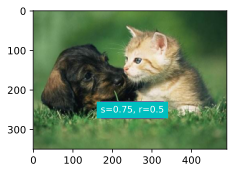

In [158]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)

show_bboxes(
    fig.axes, boxes[250, 250, :, :] * bbox_scale,
    [
        's=0.75, r=1',
        's=0.5, r=1',
        's=0.25, r=1',
        's=0.75, r=2',
        's=0.75, r=0.5'
    ]
)